In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alphabase.spectral_library.base import SpecLibBase
from alphadia.transferlearning.train import *


In [2]:
import torch
torch.set_num_threads(10)

In [3]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/d0_search/output/speclib.transfer.hdf', load_mod_seq=True)

In [4]:
# transfer_lib.precursor_df = transfer_lib.precursor_df[~transfer_lib.precursor_df['mods'].str.contains('Dimethyl@C')]

# Util function to plot the metrics

In [5]:
def plot_stats (stats_df: pd.DataFrame, loss_name: str, property: str, pre_train_dataset:str = 'all'):
    """
    Plot the the metrics of the fine-tuning process.

    Parameters
    ----------
    stats_df : pd.DataFrame
        The dataframe containing the metrics of the fine-tuning process.
    loss_name : str
        The name of the loss function used eg. 'l1_loss'.
    property : str
        The property being predicted eg. 'rt'.
    pre_train_dataset : str
        The name of the dataset used to test the model before fine-tuning. for example for rt, charge we use 'all', for ms2 we use 'validation'.
    """
    # converts stats to a dataframe 
    df = pd.DataFrame(stats_df)

    # Pivot the DataFrame

    pivot_df = df.pivot_table(index='epoch', columns=['dataset', 'property', 'metric_name'], values='value')
    num_plots = len(pivot_df['validation'][property].columns) - 1 + len(pivot_df['train'][property].columns) - 1
    fig_col = 2
    fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
    fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

    x_axis = pivot_df.index.values
    # Train and test loss
    ax[0, 0].plot(x_axis, pivot_df['train'][property][loss_name], label="Train")
    ax[0, 0].plot(x_axis, pivot_df['validation'][property][loss_name], label="Validation")
    ax[0, 0].scatter(-1, pivot_df[pre_train_dataset][property][loss_name].values[0], label="Before fine-tuning", color="red")
    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].legend()

    # Plot the learning rate
    ax[0, 1].plot(x_axis, pivot_df['train'][property]["lr"])
    ax[0, 1].set_title("Learning rate")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_ylabel("Learning rate")


    # Rest of the columns
    columns_to_plot = pivot_df['validation'][property].columns.drop(loss_name)

    for i, column_name in enumerate(columns_to_plot):
        row = (i + 2) // fig_col
        col = (i + 2) % fig_col
        ax[row, col].plot(x_axis, pivot_df['validation'][property][column_name])
        ax[row, col].set_title(column_name + " (Validation)")
        ax[row, col].set_xlabel("Epoch")
        ax[row, col].set_ylabel(column_name)




    plt.tight_layout()
    plt.show()

## RT Fine-tuning


2024-06-17 19:20:52> Predicting RT ...


  0%|          | 0/29 [00:00<?, ?it/s]c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 29/29 [00:02<00:00, 12.63it/s]


Text(0, 0.5, 'RT predicted')

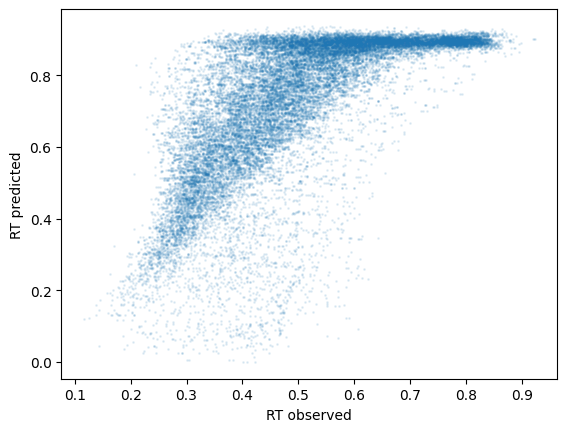

In [6]:

tune_mgr = FinetuneManager(
    device="gpu",
    settings=settings)
tune_mgr.nce = 25
tune_mgr.instrument = 'Lumos'
transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)
plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')

2024-06-17 19:20:56>  Rt model tested on all dataset with the following metrics:
2024-06-17 19:20:56>  l1_loss                       : 0.2398
2024-06-17 19:20:56>  r_square                      : 0.4829
2024-06-17 19:20:56>  r                             : 0.6949
2024-06-17 19:20:56>  slope                         : 0.5391
2024-06-17 19:20:56>  intercept                     : 0.1113
2024-06-17 19:20:56>  abs_error_95th_percentile     : 0.4317
2024-06-17 19:20:56>  Fine-tuning RT model


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorc

2024-06-17 19:21:00>  Epoch 0   Lr: 0.00010   Training loss: 0.1575   validation loss: 0.1105


c:\users\user\desktop\germany\work\mpib\alphadia\alphadia\alphadia\alphadia\transferlearning\train.py:146: RuntimeWarning: invalid value encountered in scalar divide
  or abs(val_loss - self.last_loss) / self.last_loss < self.margin


2024-06-17 19:21:02>  Epoch 1   Lr: 0.00020   Training loss: 0.0662   validation loss: 0.0536
2024-06-17 19:21:04>  Epoch 2   Lr: 0.00030   Training loss: 0.0432   validation loss: 0.0413
2024-06-17 19:21:06>  Epoch 3   Lr: 0.00040   Training loss: 0.0361   validation loss: 0.0345
2024-06-17 19:21:08>  Epoch 4   Lr: 0.00050   Training loss: 0.0316   validation loss: 0.0308
2024-06-17 19:21:10>  Epoch 5   Lr: 0.00050   Training loss: 0.0293   validation loss: 0.0296
2024-06-17 19:21:12>  Epoch 6   Lr: 0.00050   Training loss: 0.0271   validation loss: 0.0272
2024-06-17 19:21:14>  Epoch 7   Lr: 0.00050   Training loss: 0.0253   validation loss: 0.0265
2024-06-17 19:21:16>  Epoch 8   Lr: 0.00050   Training loss: 0.0243   validation loss: 0.0261
2024-06-17 19:21:18>  Epoch 9   Lr: 0.00050   Training loss: 0.0233   validation loss: 0.0253
2024-06-17 19:21:20>  Epoch 10  Lr: 0.00050   Training loss: 0.0228   validation loss: 0.0245
2024-06-17 19:21:22>  Epoch 11  Lr: 0.00050   Training loss:

100%|██████████| 29/29 [00:01<00:00, 20.26it/s]


Text(0, 0.5, 'RT predicted')

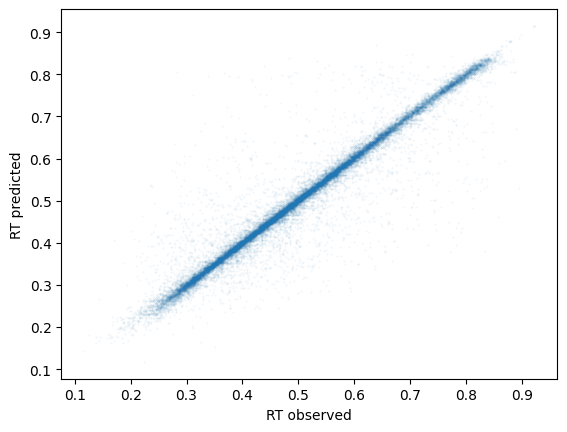

In [7]:
rt_stats = tune_mgr.finetune_rt(transfer_lib.precursor_df)

transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)

plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=0.1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')


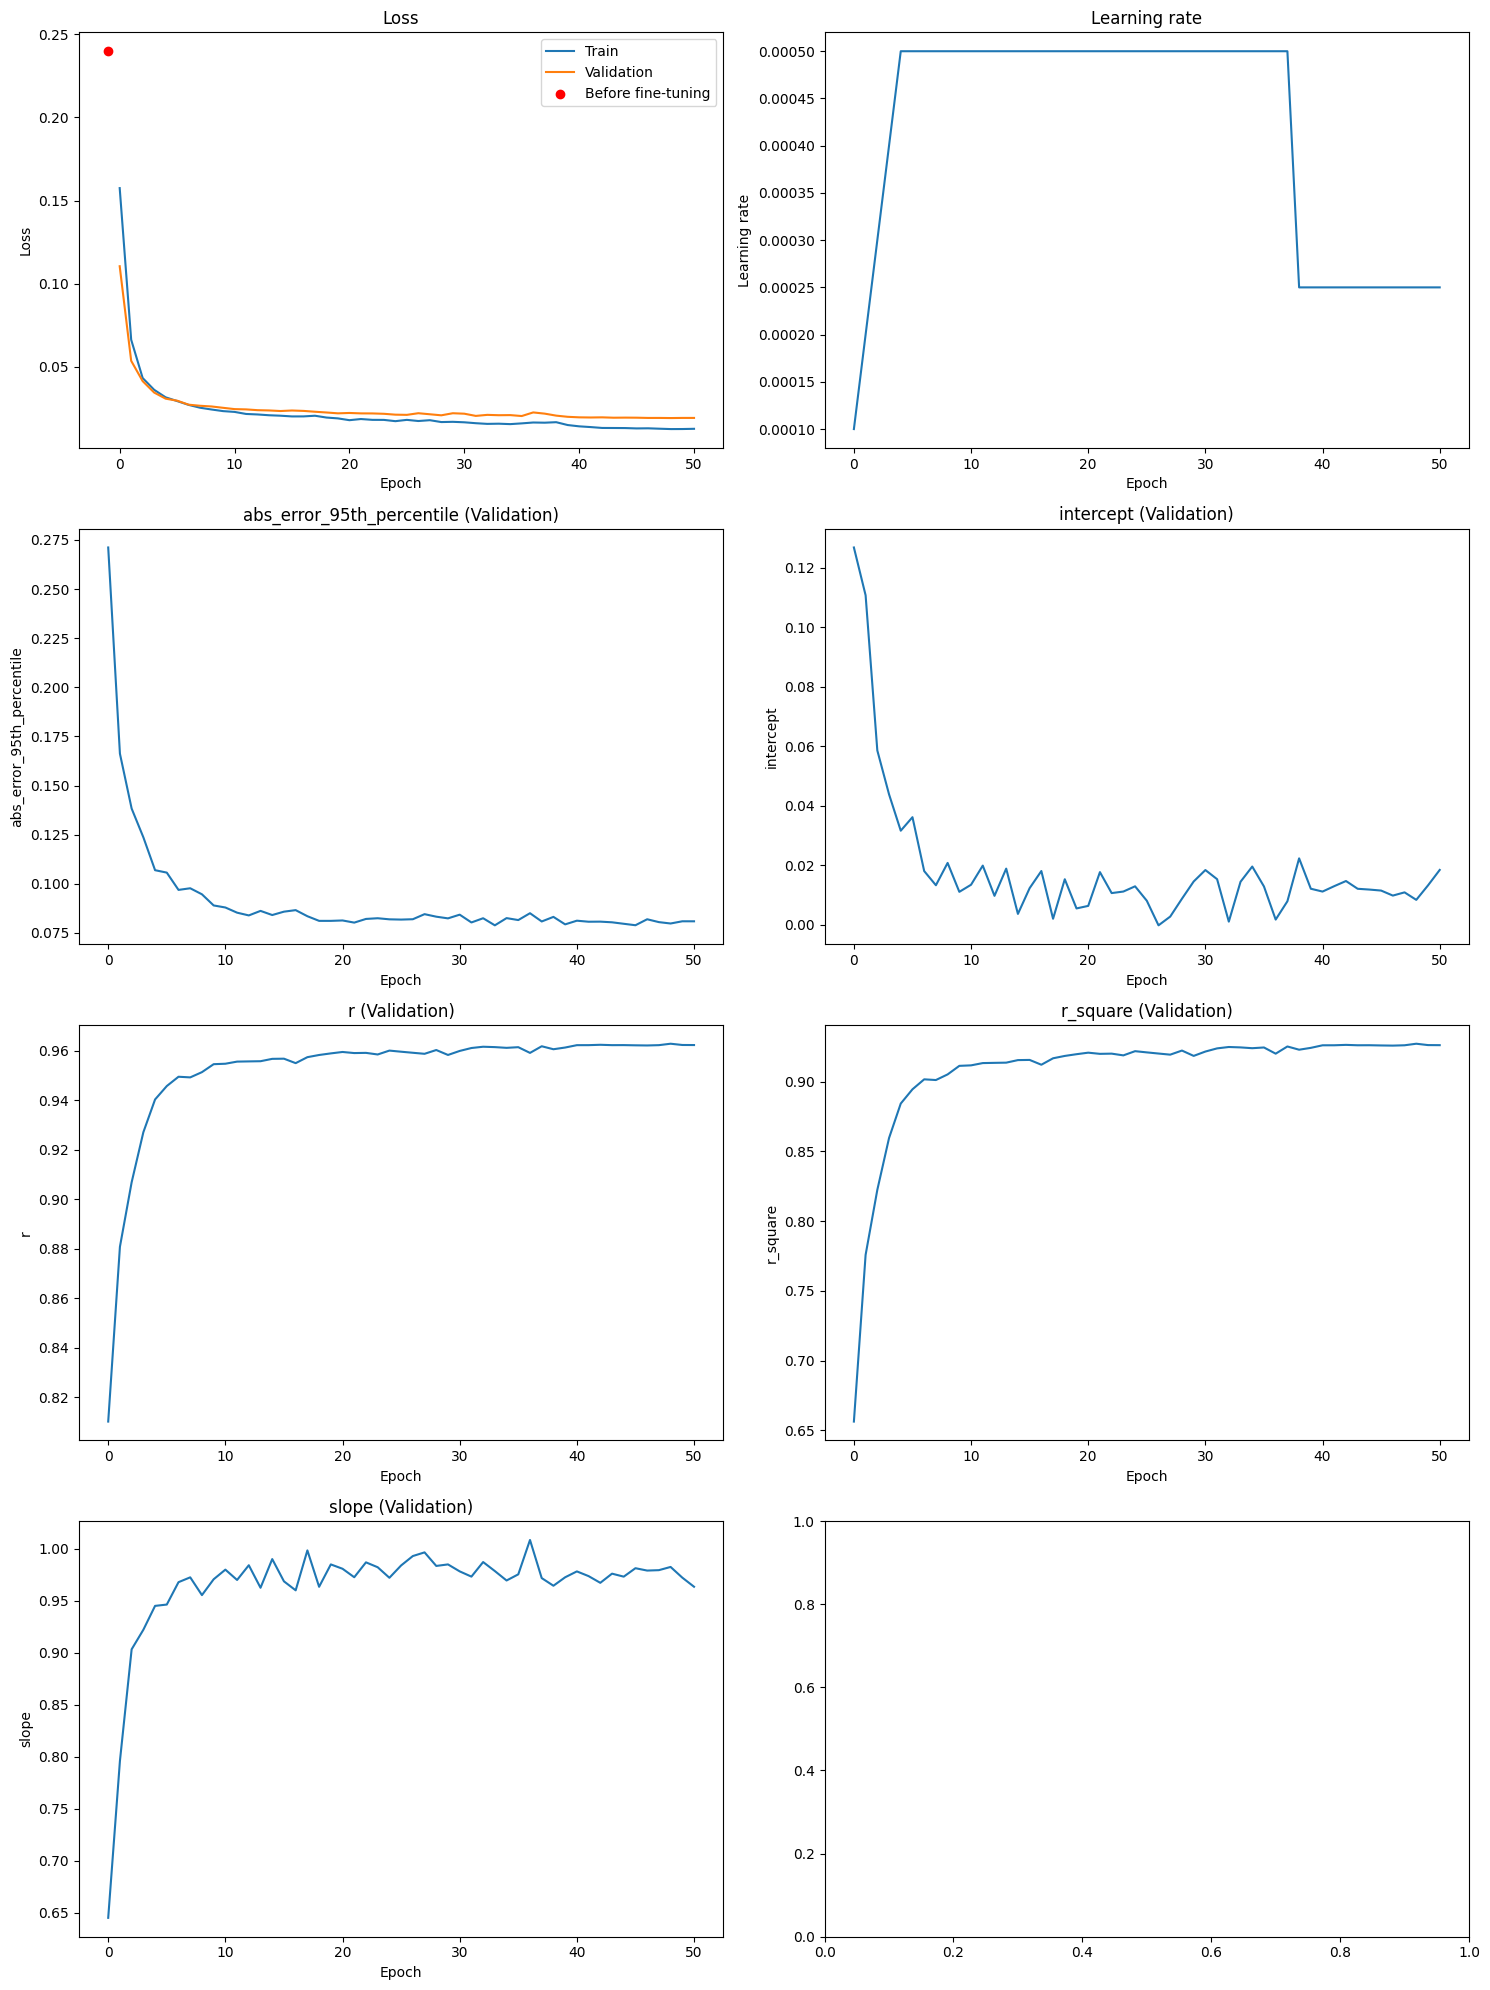

In [8]:
plot_stats(rt_stats, 'l1_loss', 'rt')

## Charge Fine-tuning

In [9]:

# Testing the charge finetuning on the transfer library
charge_stats = tune_mgr.finetune_charge(psm_df=transfer_lib.precursor_df)

2024-06-17 19:22:44>  Charge model tested on all dataset with the following metrics: 
2024-06-17 19:22:44>  ce_loss                       : 0.6474
2024-06-17 19:22:44>  accuracy                      : 0.6371
2024-06-17 19:22:44>  precision                     : 0.2919
2024-06-17 19:22:44>  recall                        : 0.2648
2024-06-17 19:22:44>  Fine-tuning Charge model


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:22:48>  Epoch 0   Lr: 0.00010   Training loss: 0.5714   validation loss: 0.5522


c:\users\user\desktop\germany\work\mpib\alphadia\alphadia\alphadia\alphadia\transferlearning\train.py:146: RuntimeWarning: invalid value encountered in scalar divide
  or abs(val_loss - self.last_loss) / self.last_loss < self.margin
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:22:51>  Epoch 1   Lr: 0.00020   Training loss: 0.3917   validation loss: 0.4804
2024-06-17 19:22:55>  Epoch 2   Lr: 0.00030   Training loss: 0.3212   validation loss: 0.3708
2024-06-17 19:22:58>  Epoch 3   Lr: 0.00040   Training loss: 0.3079   validation loss: 0.2937
2024-06-17 19:23:02>  Epoch 4   Lr: 0.00050   Training loss: 0.2649   validation loss: 0.3721
2024-06-17 19:23:05>  Epoch 5   Lr: 0.00050   Training loss: 0.2678   validation loss: 0.3518


c:\users\user\desktop\germany\work\mpib\alphadia\alphadia\alphadia\alphadia\transferlearning\metrics.py:393: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


2024-06-17 19:23:08>  Epoch 6   Lr: 0.00050   Training loss: 0.2802   validation loss: 0.2877
2024-06-17 19:23:12>  Epoch 7   Lr: 0.00050   Training loss: 0.2565   validation loss: 0.3483
2024-06-17 19:23:16>  Epoch 8   Lr: 0.00050   Training loss: 0.2187   validation loss: 0.3969
2024-06-17 19:23:19>  Epoch 9   Lr: 0.00050   Training loss: 0.2175   validation loss: 0.4209
2024-06-17 19:23:22>  Epoch 10  Lr: 0.00050   Training loss: 0.2065   validation loss: 0.3313
2024-06-17 19:23:26>  Epoch 11  Lr: 0.00050   Training loss: 0.2415   validation loss: 0.3253
2024-06-17 19:23:29>  Epoch 12  Lr: 0.00050   Training loss: 0.1939   validation loss: 0.2799
2024-06-17 19:23:32>  Epoch 13  Lr: 0.00050   Training loss: 0.1880   validation loss: 0.2557
2024-06-17 19:23:36>  Epoch 14  Lr: 0.00050   Training loss: 0.1851   validation loss: 0.2818
2024-06-17 19:23:39>  Epoch 15  Lr: 0.00050   Training loss: 0.1845   validation loss: 0.2294
2024-06-17 19:23:43>  Epoch 16  Lr: 0.00050   Training loss:

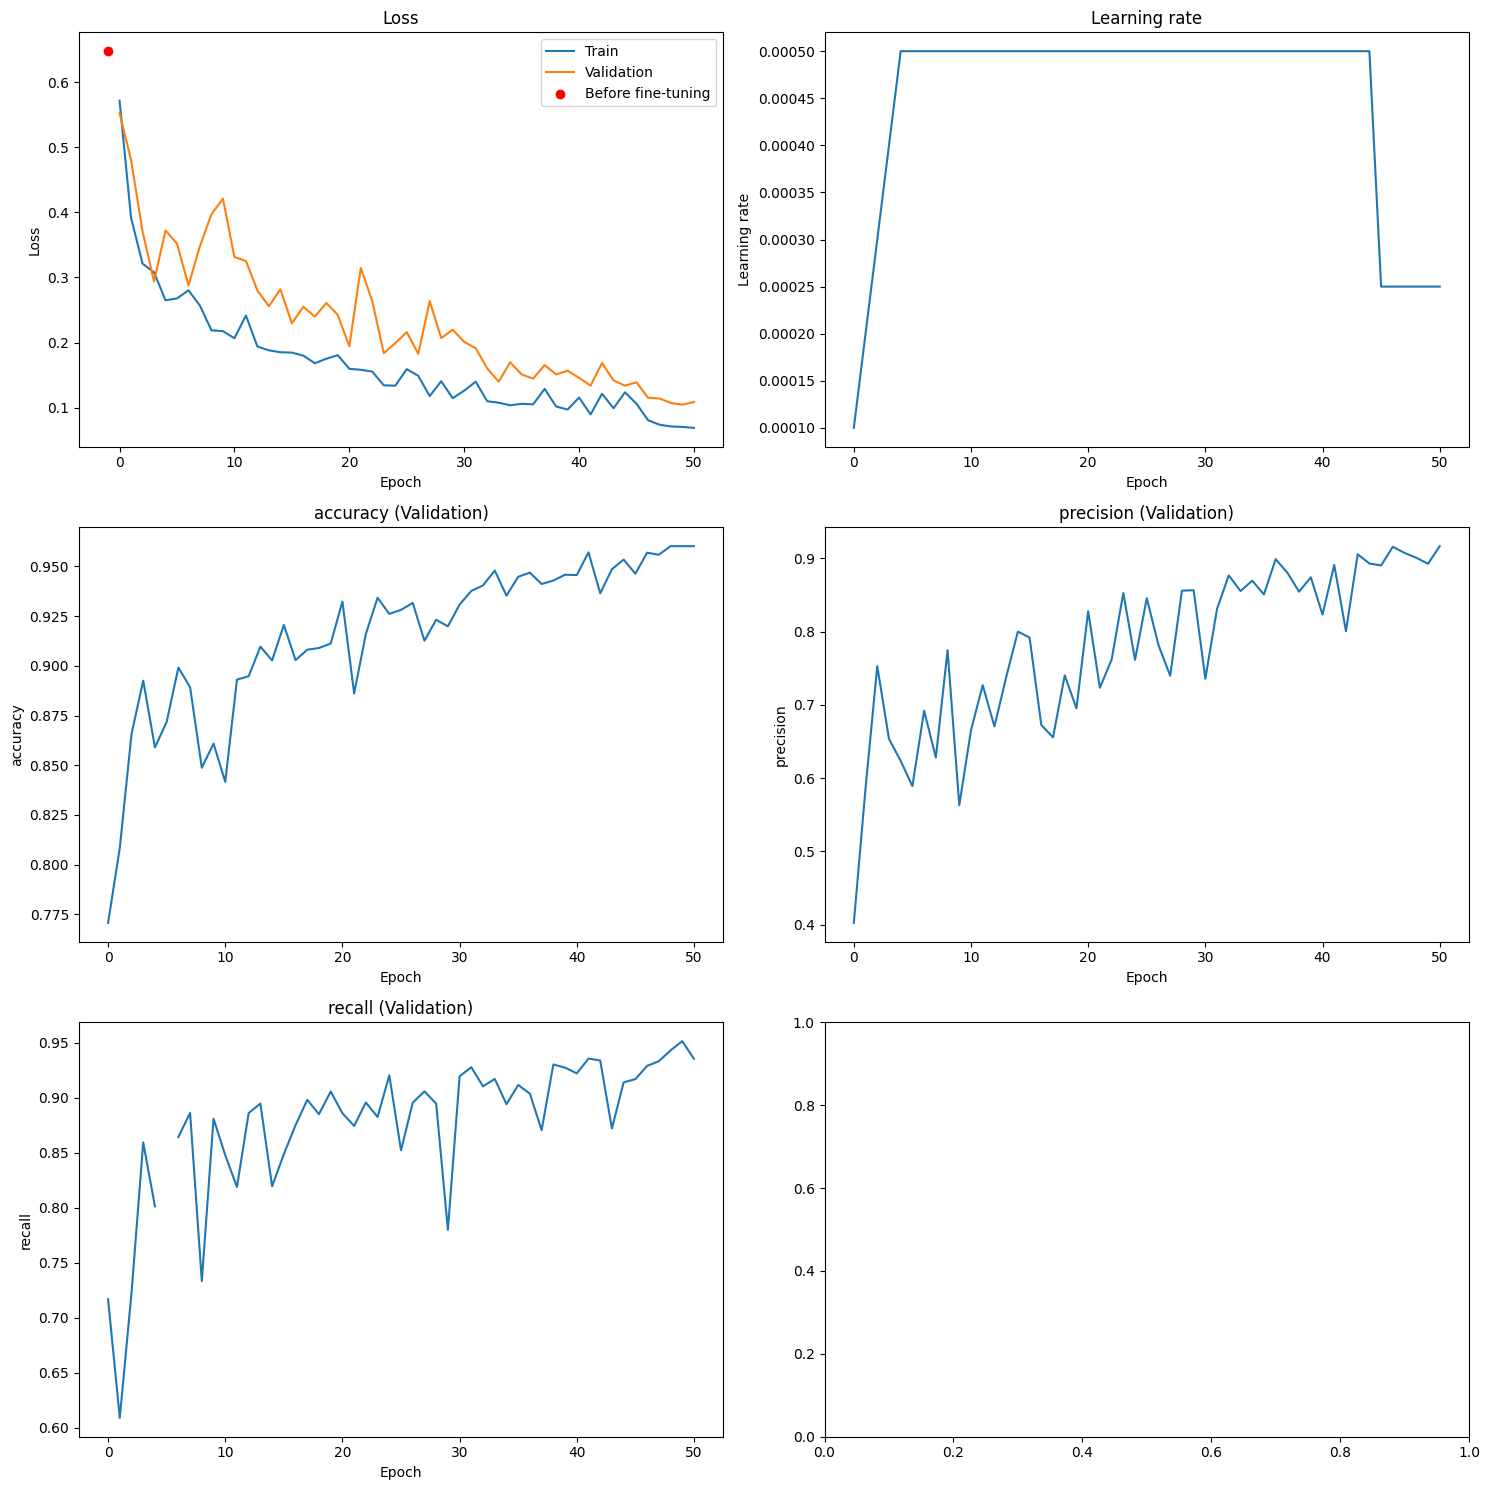

In [10]:
plot_stats(charge_stats, 'ce_loss', 'charge')

## MS2 Fine-tuning

In [11]:
# Uncomment the following line to only finetune the ms2 on high quality spectra
# transfer_lib.precursor_df = transfer_lib.precursor_df[transfer_lib.precursor_df['use_for_ms2']]


In [12]:
def calculate_similarity(precursor_df_a, precursor_df_b, intensity_df_a, intensity_df_b):

    _a_df = precursor_df_a[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()
    _b_df = precursor_df_b[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()

    _merged_df = pd.merge(_a_df, _b_df, on='precursor_idx', suffixes=('_a', '_b'))
    # keep only first precursor
    _merged_df = _merged_df.drop_duplicates(subset='precursor_idx', keep='first')
    similarity_list = []

    for i, (start_a, stop_a, start_b, stop_b) in enumerate(zip(_merged_df['frag_start_idx_a'], _merged_df['frag_stop_idx_a'], _merged_df['frag_start_idx_b'], _merged_df['frag_stop_idx_b'])):
        observed_intensity = intensity_df_a.iloc[start_a:stop_a, :4].values.flatten()
        predicted_intensity = intensity_df_b.iloc[start_b:stop_b, :4].values.flatten()

        similarity = np.dot(observed_intensity, predicted_intensity) / (np.linalg.norm(observed_intensity) * np.linalg.norm(predicted_intensity))
        similarity_list.append({'similarity': similarity, 'index': i, 'precursor_idx': _merged_df.iloc[i]['precursor_idx']})

    return pd.DataFrame(similarity_list)

2024-06-17 19:25:45> Predicting MS2 ...


100%|██████████| 29/29 [00:02<00:00, 10.32it/s]


0.7331870840880088


Text(0.5, 1.0, 'Similarity between observed and predicted MS2 spectra before fine-tuning')

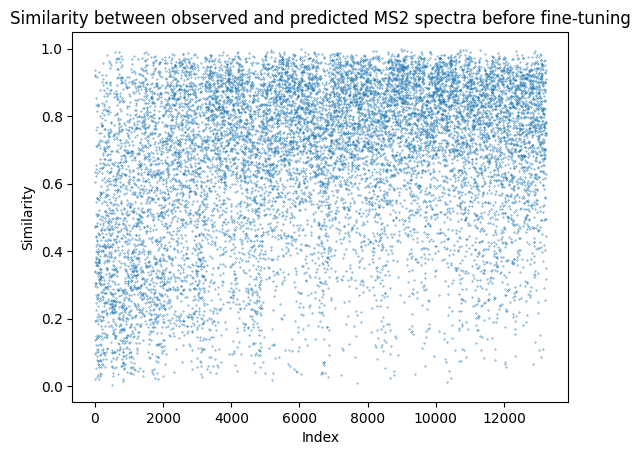

In [13]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=['ms2'])

precursor_after_df = res['precursor_df']
fragment_mz_after_df = res['fragment_mz_df']
fragment_intensity_after_df = res['fragment_intensity_df']
similarity_after_df = calculate_similarity(precursor_after_df, transfer_lib.precursor_df, fragment_intensity_after_df, transfer_lib.fragment_intensity_df)
print(similarity_after_df['similarity'].median())
plt.scatter(similarity_after_df['index'], similarity_after_df['similarity'], s=0.1)
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.title('Similarity between observed and predicted MS2 spectra before fine-tuning')

In [14]:

# Testing the ms2 finetuning on the transfer library
ms2_stats = tune_mgr.finetune_ms2(psm_df=transfer_lib.precursor_df.copy(), matched_intensity_df=transfer_lib.fragment_intensity_df.copy())

100%|██████████| 5779/5779 [00:01<00:00, 3684.63it/s]


2024-06-17 19:26:00>  Ms2 model tested on validation dataset with the following metrics:
2024-06-17 19:26:00>  l1_loss                       : 0.0323
2024-06-17 19:26:00>  PCC-mean                      : 0.7512
2024-06-17 19:26:00>  COS-mean                      : 0.7679
2024-06-17 19:26:00>  SA-mean                       : 0.5574
2024-06-17 19:26:00>  SPC-mean                      : 0.6412
2024-06-17 19:26:00>  Fine-tuning MS2 model


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:26:07>  Epoch 0   Lr: 0.00010   Training loss: 0.0216   validation loss: 0.0244


c:\users\user\desktop\germany\work\mpib\alphadia\alphadia\alphadia\alphadia\transferlearning\train.py:146: RuntimeWarning: invalid value encountered in scalar divide
  or abs(val_loss - self.last_loss) / self.last_loss < self.margin
c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:26:14>  Epoch 1   Lr: 0.00020   Training loss: 0.0188   validation loss: 0.0221


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:26:20>  Epoch 2   Lr: 0.00030   Training loss: 0.0182   validation loss: 0.0221


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:26:27>  Epoch 3   Lr: 0.00040   Training loss: 0.0179   validation loss: 0.0224


c:\Users\USER\anaconda3\envs\alpha\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-06-17 19:26:34>  Epoch 4   Lr: 0.00050   Training loss: 0.0175   validation loss: 0.0219
2024-06-17 19:26:40>  Epoch 5   Lr: 0.00050   Training loss: 0.0178   validation loss: 0.0225
2024-06-17 19:26:49>  Epoch 6   Lr: 0.00050   Training loss: 0.0178   validation loss: 0.0210
2024-06-17 19:26:56>  Epoch 7   Lr: 0.00050   Training loss: 0.0170   validation loss: 0.0202
2024-06-17 19:27:03>  Epoch 8   Lr: 0.00050   Training loss: 0.0159   validation loss: 0.0207
2024-06-17 19:27:10>  Epoch 9   Lr: 0.00050   Training loss: 0.0163   validation loss: 0.0210
2024-06-17 19:27:17>  Epoch 10  Lr: 0.00050   Training loss: 0.0165   validation loss: 0.0198
2024-06-17 19:27:23>  Epoch 11  Lr: 0.00050   Training loss: 0.0162   validation loss: 0.0204
2024-06-17 19:27:30>  Epoch 12  Lr: 0.00050   Training loss: 0.0156   validation loss: 0.0193
2024-06-17 19:27:36>  Epoch 13  Lr: 0.00050   Training loss: 0.0155   validation loss: 0.0193
2024-06-17 19:27:42>  Epoch 14  Lr: 0.00050   Training loss:

2024-06-17 19:31:49> Predicting MS2 ...


100%|██████████| 29/29 [00:02<00:00, 11.29it/s]


0.9334270435588548


Text(0.5, 1.0, 'Similarity between observed and predicted MS2 spectra after fine-tuning')

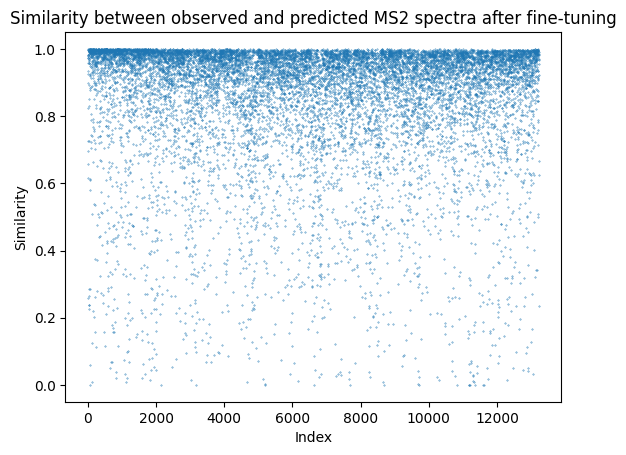

In [15]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=['ms2'])

precursor_after_df = res['precursor_df']
fragment_mz_after_df = res['fragment_mz_df']
fragment_intensity_after_df = res['fragment_intensity_df']
similarity_after_df = calculate_similarity(precursor_after_df, transfer_lib.precursor_df, fragment_intensity_after_df, transfer_lib.fragment_intensity_df)
print(similarity_after_df['similarity'].median())
plt.scatter(similarity_after_df['index'], similarity_after_df['similarity'], s=0.1)
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.title('Similarity between observed and predicted MS2 spectra after fine-tuning')


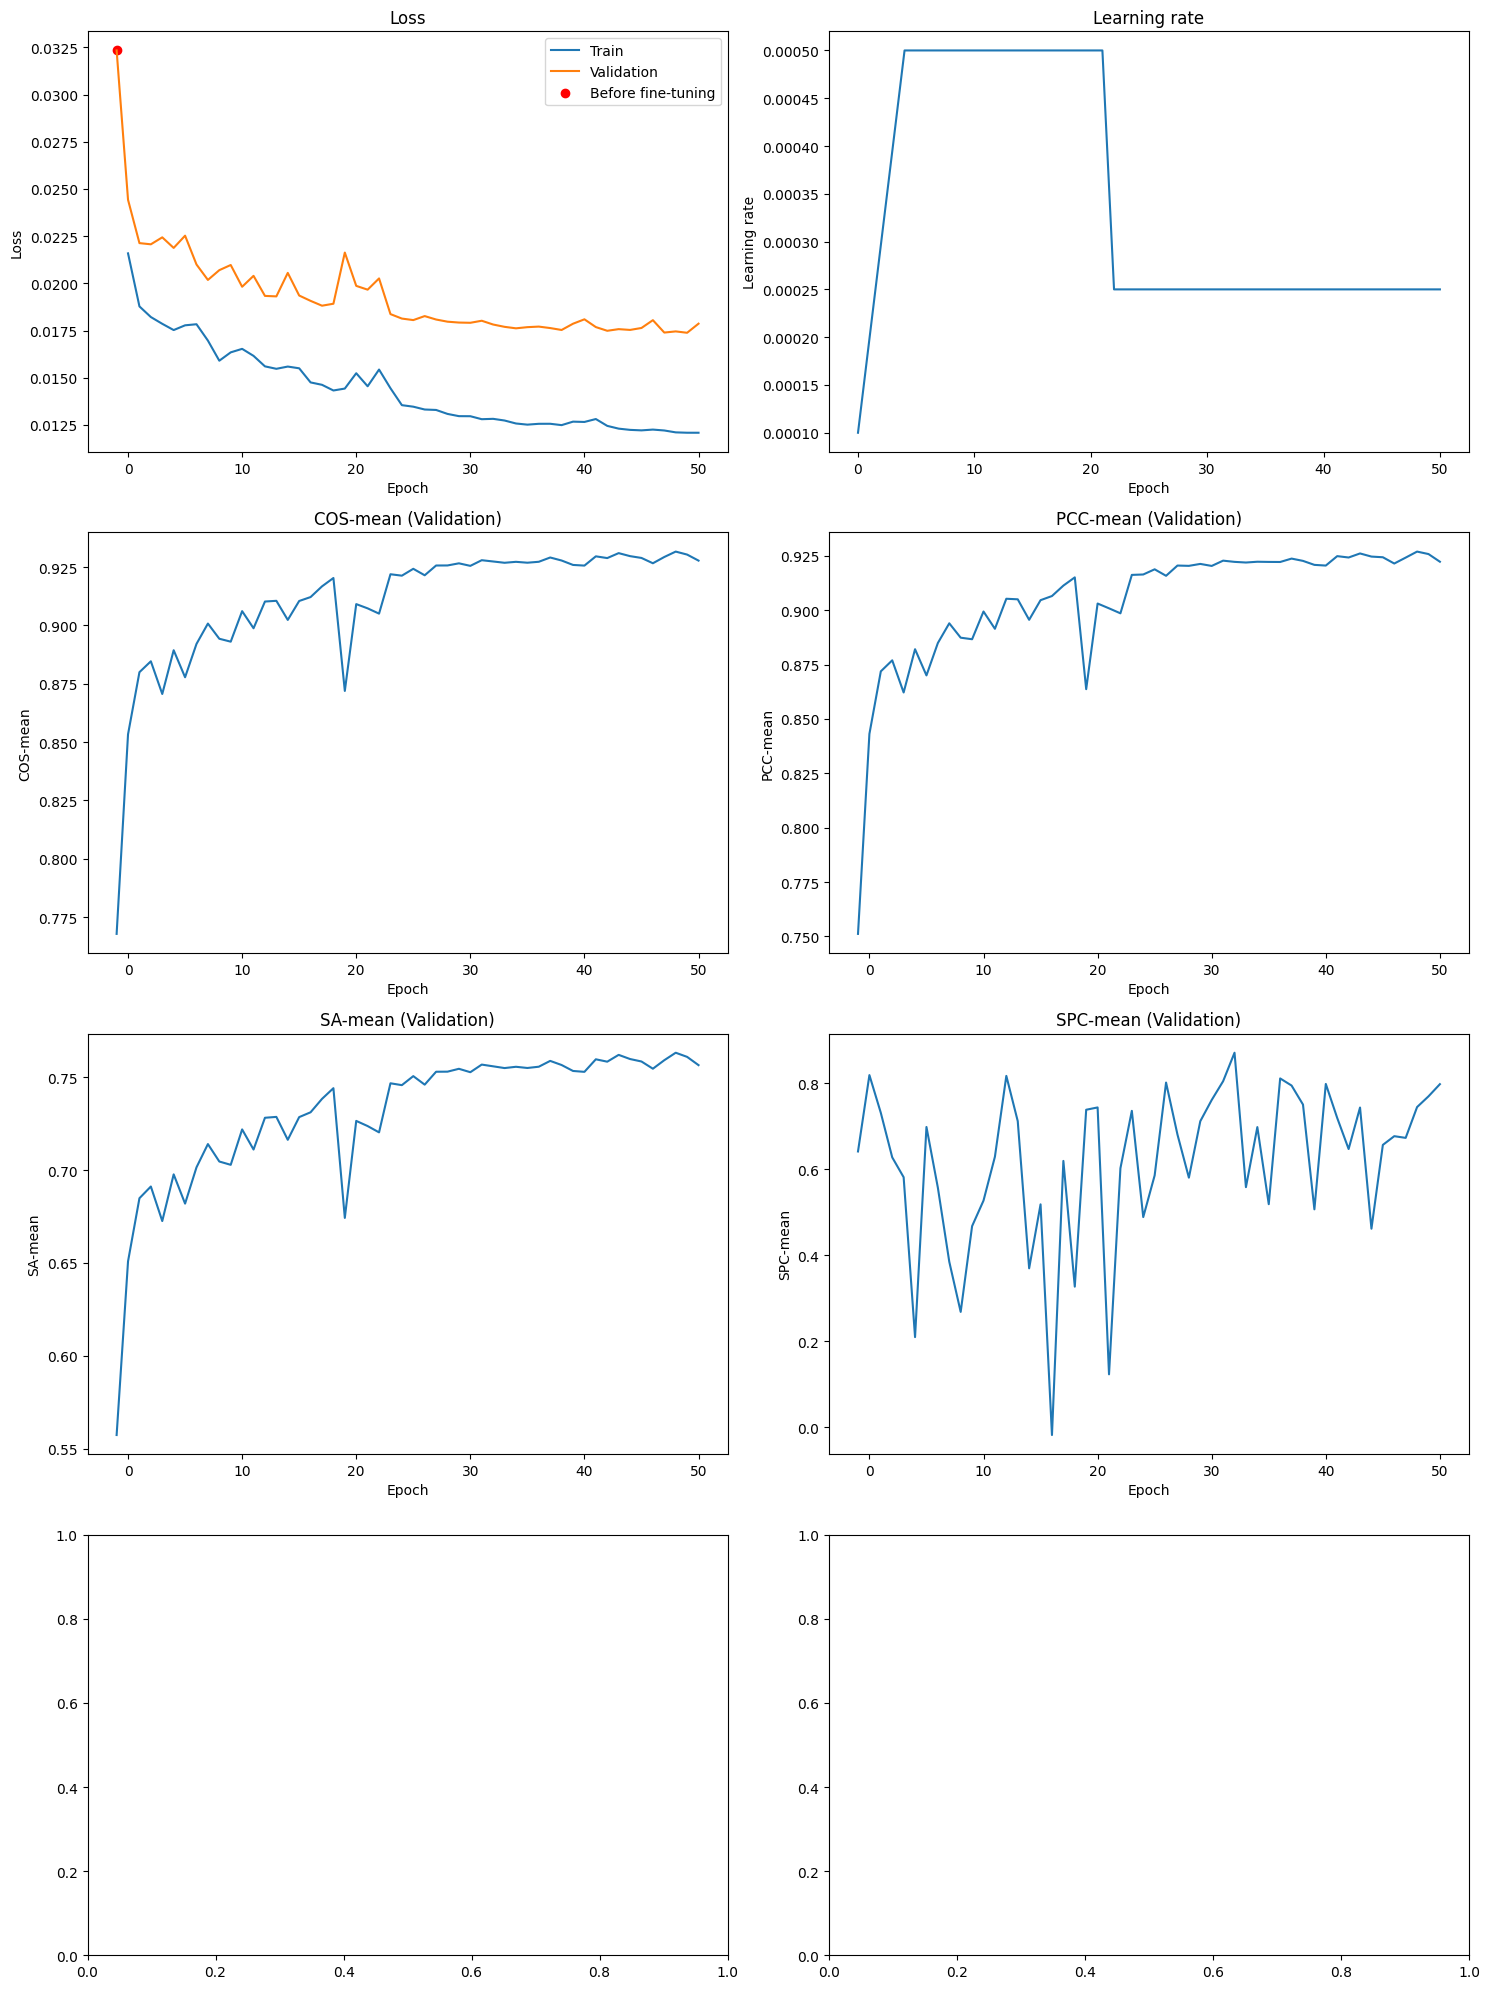

In [16]:
plot_stats(ms2_stats, 'l1_loss', 'ms2', pre_train_dataset='validation')